In [9]:
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from transformers.optimization import get_constant_schedule_with_warmup
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
print("DONE!!!")

DONE!!!


In [10]:
!pip install peft

In [11]:
print("Datasets......\n1. SNLI \n2. MULTI-NLI\n3. SICK")
for i in range(3):
    dataset_choice = int(input("Enter choice :"))
    if dataset_choice == 1:
        dataset = load_dataset("snli")
        break
    elif dataset_choice == 2:
        dataset = load_dataset("multi_nli")
        break
    elif dataset_choice == 3:
        dataset =  load_dataset("sick")
        break
else:
    print("Invalid Choices Thrice....\nRun the program again")
    exit()

Datasets......
1. SNLI 
2. MULTI-NLI
3. SICK


Enter choice : 3


In [12]:
class NLIDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        return {
            'premise': item['premise'],
            'hypothesis': item['hypothesis'],
            'label': item['label']
        }

print("DONE!!!")

DONE!!!


In [13]:
print(dataset_choice, end = "-")

if dataset_choice == 1:
    print("SNLI")
    dataset['train'] = dataset['train'].filter(lambda sen: sen['label'] != -1)
    dataset['validation'] = dataset['validation'].filter(lambda sen: sen['label'] != -1)
    dataset['test'] = dataset['test'].filter(lambda sen: sen['label'] != -1)
    train_data = dataset['train']
    test_data = dataset['test']
    validation_data = dataset['validation']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['premise'],
        'hypothesis': train_data['hypothesis'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),
        'premise': validation_data['premise'],
        'hypothesis': validation_data['hypothesis'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)), 
        'premise': test_data['premise'],
        'hypothesis': test_data['hypothesis'],
        'label': test_data['label']
    })
    
elif dataset_choice == 2:
    print("MULTI-NLI")
    train_data = dataset['train']
    validation_data = dataset['validation_matched']
    test_data = dataset['validation_mismatched']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['premise'],
        'hypothesis': train_data['hypothesis'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),  
        'premise': validation_data['premise'],
        'hypothesis': validation_data['hypothesis'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)),  
        'premise': test_data['premise'],
        'hypothesis': test_data['hypothesis'],
        'label': test_data['label']
    })
    
elif dataset_choice == 3:
    print("SICK")
    train_data = dataset['train']
    validation_data = dataset['validation']
    test_data = dataset['test']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['sentence_A'],
        'hypothesis': train_data['sentence_B'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),
        'premise': validation_data['sentence_A'],
        'hypothesis': validation_data['sentence_B'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)), 
        'premise': test_data['sentence_A'],
        'hypothesis': test_data['sentence_B'],
        'label': test_data['label']
    })

print("DONE!!!")

3-SICK
DONE!!!


In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
optimizer = AdamW(model.parameters(), lr=1e-5)

print(dataset_choice)
# Datasets......
train_ds = NLIDataset(train_dataset)
val_ds = NLIDataset(val_dataset)
test_ds = NLIDataset(test_dataset)

# DataLoaders......
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)
print(len(train_loader), len(val_loader), len(test_loader))
print("DONE!!!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3
139 16 154
DONE!!!


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r = 1,
                        lora_alpha = 32,
                        lora_dropout = 0.01,
                        target_modules=['query', 'key', 'value'])

In [16]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=1, target_modules={'query', 'value', 'key'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)

In [17]:
# from transformers import (
#     AutoTokenizer,
#     AutoConfig,
#     AutoModelForSequenceClassification,
#     DataCollatorWithPadding,
#     TrainingArguments,
#     Trainer)

In [20]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import torch
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
base_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)

all_preds = []
epochs = 10
for epoch in range(epochs):
    print(epoch + 1, "Epoch.......")

    # Training.....
    correct_predictions = 0
    total_predictions = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} Training"):
        optimizer.zero_grad()
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
        labels = batch['label'].to(device)

        outputs = model(**inputs)
        logits = outputs.logits

        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)

    train_accuracy = correct_predictions / total_predictions
    print("Train Accuracy:", train_accuracy)

    # Validation....
    model.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
            labels = batch['label'].to(device)
            outputs = model(**inputs)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print("Validation Accuracy:", val_accuracy)
    
    # Testingggg.....
    test_labels = []
    test_preds = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
            labels = batch['label'].to(device)
            outputs = model(**inputs)
            test_labels.extend(labels.cpu().numpy())
            test_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds)
    all_preds.append(test_preds)
    print("Test Accuracy:", test_accuracy)
    print()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


trainable params: 648,195 || all params: 125,296,134 || trainable%: 0.517330407017985
1 Epoch.......


Epoch 1 Training: 100%|██████████| 139/139 [00:14<00:00,  9.76it/s]


Train Accuracy: 0.5685965307501689


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.41it/s]


Validation Accuracy: 0.5676767676767677


Testing: 100%|██████████| 154/154 [00:07<00:00, 20.67it/s]


Test Accuracy: 0.5686913982878108

2 Epoch.......


Epoch 2 Training: 100%|██████████| 139/139 [00:13<00:00, 10.02it/s]


Train Accuracy: 0.5685965307501689


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.45it/s]


Validation Accuracy: 0.5676767676767677


Testing: 100%|██████████| 154/154 [00:07<00:00, 20.81it/s]


Test Accuracy: 0.5686913982878108

3 Epoch.......


Epoch 3 Training: 100%|██████████| 139/139 [00:13<00:00, 10.02it/s]


Train Accuracy: 0.6805586843883757


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.48it/s]


Validation Accuracy: 0.8202020202020202


Testing: 100%|██████████| 154/154 [00:07<00:00, 20.66it/s]


Test Accuracy: 0.8083978801467591

4 Epoch.......


Epoch 4 Training: 100%|██████████| 139/139 [00:13<00:00,  9.99it/s]


Train Accuracy: 0.82090560937148


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.46it/s]


Validation Accuracy: 0.8383838383838383


Testing: 100%|██████████| 154/154 [00:07<00:00, 20.79it/s]


Test Accuracy: 0.842845495311863

5 Epoch.......


Epoch 5 Training: 100%|██████████| 139/139 [00:13<00:00,  9.97it/s]


Train Accuracy: 0.850642036494706


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.50it/s]


Validation Accuracy: 0.8424242424242424


Testing: 100%|██████████| 154/154 [00:07<00:00, 20.71it/s]


Test Accuracy: 0.8501834488381573

6 Epoch.......


Epoch 6 Training: 100%|██████████| 139/139 [00:13<00:00,  9.99it/s]


Train Accuracy: 0.8594277990538409


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.42it/s]


Validation Accuracy: 0.8646464646464647


Testing: 100%|██████████| 154/154 [00:07<00:00, 20.73it/s]


Test Accuracy: 0.864655523848349

7 Epoch.......


Epoch 7 Training: 100%|██████████| 139/139 [00:13<00:00, 10.03it/s]


Train Accuracy: 0.8668619058346474


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.55it/s]


Validation Accuracy: 0.8646464646464647


Testing: 100%|██████████| 154/154 [00:07<00:00, 20.81it/s]


Test Accuracy: 0.8697513249082756

8 Epoch.......


Epoch 8 Training: 100%|██████████| 139/139 [00:13<00:00,  9.98it/s]


Train Accuracy: 0.8756476683937824


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.62it/s]


Validation Accuracy: 0.8565656565656565


Testing: 100%|██████████| 154/154 [00:07<00:00, 20.69it/s]


Test Accuracy: 0.8707704851202609

9 Epoch.......


Epoch 9 Training: 100%|██████████| 139/139 [00:13<00:00,  9.95it/s]


Train Accuracy: 0.8812795674701509


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.57it/s]


Validation Accuracy: 0.8707070707070707


Testing: 100%|██████████| 154/154 [00:07<00:00, 20.76it/s]


Test Accuracy: 0.8738279657562169

10 Epoch.......


Epoch 10 Training: 100%|██████████| 139/139 [00:13<00:00,  9.96it/s]


Train Accuracy: 0.8857850867312458


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.53it/s]


Validation Accuracy: 0.8646464646464647


Testing: 100%|██████████| 154/154 [00:07<00:00, 20.78it/s]

Test Accuracy: 0.8750509580105993



Test Accuracy : 87.51%
F1 Score : 87.45%
Recall Score : 87.51%
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1404
           1       0.88      0.91      0.90      2790
           2       0.88      0.82      0.85       712

    accuracy                           0.88      4906
   macro avg       0.87      0.85      0.86      4906
weighted avg       0.87      0.88      0.87      4906



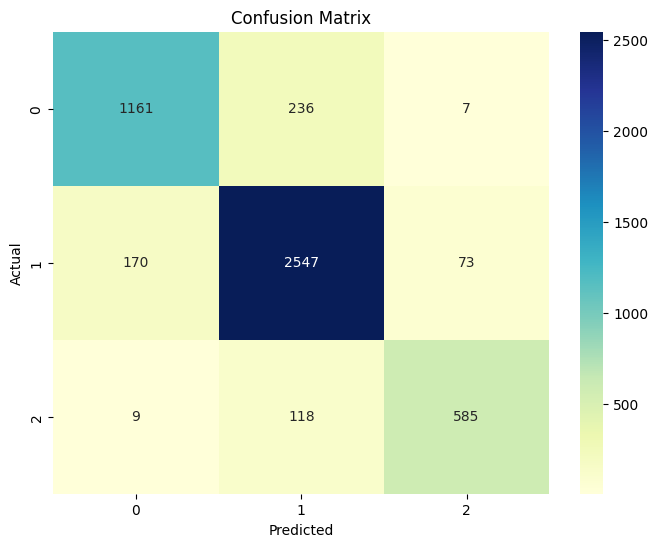

In [21]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score
import seaborn as sns


# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Recall Score : {:.2f}%".format(recall * 100))

# classification_report
class_report = classification_report(test_labels, test_preds)
print("Classification Report:")
print(class_report)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()